In [5]:
import os
import cv2
import torch
import random
import numpy as np
import shutil
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import ViTModel
from tqdm import tqdm

# Paths in Kaggle format
data_root = "/kaggle/input/violence-detection-dataset/violence-detection-dataset"
output_root = "/kaggle/working/frames"
categories = ["violent", "non-violent"]
FRAME_RATE = 5  # Extract every 5th frame
SPLIT_RATIO = 0.8  # 80% train, 20% validation

# Ensure output directory exists
os.makedirs(output_root, exist_ok=True)

# Frame extraction function
def extract_frames(video_path, output_folder, frame_rate=5):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_rate == 0:
            frame_filename = os.path.join(output_folder, f"{os.path.basename(video_path)}_frame{frame_count}.jpg")
            cv2.imwrite(frame_filename, frame)
        frame_count += 1
    
    cap.release()

# Extract frames for both categories
for category in categories:
    category_path = os.path.join(data_root, category)
    output_category_path = os.path.join(output_root, category)
    os.makedirs(output_category_path, exist_ok=True)
    
    for cam_folder in os.listdir(category_path):
        cam_path = os.path.join(category_path, cam_folder)
        if not os.path.isdir(cam_path):
            continue  # Skip if not a folder
        
        for video_file in tqdm(os.listdir(cam_path), desc=f"Processing {category}/{cam_folder}"):
            video_path = os.path.join(cam_path, video_file)
            if video_file.endswith(".mp4"):
                extract_frames(video_path, output_category_path, FRAME_RATE)

# Define dataset class
class ViolenceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        
        for category in categories:
            category_path = os.path.join(root_dir, category)
            label = 1 if category == "violent" else 0
            for img_file in os.listdir(category_path):
                self.images.append(os.path.join(category_path, img_file))
                self.labels.append(label)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create dataset and split
full_dataset = ViolenceDataset(output_root, transform=transform)
if len(full_dataset) == 0:
    raise ValueError("Dataset is empty. Please check the data directory structure and extracted frames.")
train_size = int(SPLIT_RATIO * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Define ViViT model
class ViViTClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(ViViTClassifier, self).__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.fc = nn.Linear(768, num_classes)
    
    def forward(self, x):
        outputs = self.vit(x).last_hidden_state[:, 0, :]
        return self.fc(outputs)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViViTClassifier().to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
EPOCHS = 5
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")
    
print("Training complete!")

Processing non-violent/cam2: 100%|██████████| 60/60 [01:02<00:00,  1.04s/it]


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1/5: 100%|██████████| 301/301 [04:53<00:00,  1.03it/s]


Epoch 1, Loss: 0.1750


Epoch 2/5:  11%|█         | 33/301 [00:35<04:46,  1.07s/it]


KeyboardInterrupt: 

In [3]:
!pip install decord

In [4]:
import os
import cv2
import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import VideoMAEModel
from decord import VideoReader, cpu
from tqdm import tqdm

# Paths in Kaggle format
data_root = "/kaggle/input/violence-detection-dataset/violence-detection-dataset"
categories = ["violent", "non-violent"]
SPLIT_RATIO = 0.8  # 80% train, 20% validation
NUM_FRAMES = 16  # Number of frames per video clip

# Define dataset class
class ViolenceDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_frames=16):
        self.root_dir = root_dir
        self.transform = transform
        self.num_frames = num_frames
        self.videos = []
        self.labels = []
        
        for category in categories:
            category_path = os.path.join(root_dir, category)
            label = 1 if category == "violent" else 0
            for cam_folder in os.listdir(category_path):
                cam_path = os.path.join(category_path, cam_folder)
                if not os.path.isdir(cam_path):
                    continue  # Skip if not a folder
                for video_file in os.listdir(cam_path):
                    if video_file.endswith(".mp4"):
                        self.videos.append(os.path.join(cam_path, video_file))
                        self.labels.append(label)
    
    def __len__(self):
        return len(self.videos)
    
    def __getitem__(self, idx):
        video_path = self.videos[idx]
        vr = VideoReader(video_path, ctx=cpu(0))
        total_frames = len(vr)
        frame_indices = np.linspace(0, total_frames - 1, self.num_frames, dtype=int)
        frames = [vr[i].asnumpy() for i in frame_indices]
        frames = np.stack(frames)
        
        if self.transform:
            frames = [self.transform(frame) for frame in frames]
            frames = torch.stack(frames)
        
        return frames, self.labels[idx]

# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create dataset and split
full_dataset = ViolenceDataset(data_root, transform=transform, num_frames=NUM_FRAMES)
print(len(full_dataset))
if len(full_dataset) == 0:
    raise ValueError("Dataset is empty. Please check the data directory structure and videos.")
train_size = int(SPLIT_RATIO * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Define ViViT model
class ViViTClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(ViViTClassifier, self).__init__()
        self.vivit = VideoMAEModel.from_pretrained("MCG-NJU/videomae-base")
        self.fc = nn.Linear(768, num_classes)
    
    def forward(self, x):
        outputs = self.vivit(x).last_hidden_state[:, 0, :]
        return self.fc(outputs)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViViTClassifier().to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    
    for videos, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        videos, labels = videos.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(videos)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")
    
print("Training complete!")


350


config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/377M [00:00<?, ?B/s]

Epoch 1/10: 100%|██████████| 70/70 [05:56<00:00,  5.10s/it]


Epoch 1, Loss: 0.6386


Epoch 2/10: 100%|██████████| 70/70 [05:44<00:00,  4.93s/it]


Epoch 2, Loss: 0.4946


Epoch 3/10:  16%|█▌        | 11/70 [00:54<04:54,  4.98s/it]


KeyboardInterrupt: 

In [4]:
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0 
    total = 0      
    
    with torch.no_grad():
        for videos, labels in tqdm(dataloader, desc="Evaluating"):
            videos, labels = videos.to(device), labels.to(device)
            outputs = model(videos)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    accuracy = correct / total * 100
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

# Create test dataloader
test_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Evaluate accuracy on test set
evaluate(model, test_loader, device)


Evaluating: 100%|██████████| 18/18 [01:14<00:00,  4.11s/it]

Test Accuracy: 85.71%


85.71428571428571

In [5]:
import os
import cv2
import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
from decord import VideoReader, cpu
from tqdm import tqdm

# Paths in Kaggle format
data_root = "/kaggle/input/violence-detection-dataset/violence-detection-dataset"
categories = ["violent", "non-violent"]
SPLIT_RATIO = 0.8  # 80% train, 20% validation
NUM_FRAMES = 16  # Number of frames per video clip

# Define dataset class
class ViolenceDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_frames=16):
        self.root_dir = root_dir
        self.transform = transform
        self.num_frames = num_frames
        self.videos = []
        self.labels = []
        
        for category in categories:
            category_path = os.path.join(root_dir, category)
            label = 1 if category == "violent" else 0
            for cam_folder in os.listdir(category_path):
                cam_path = os.path.join(category_path, cam_folder)
                if not os.path.isdir(cam_path):
                    continue  # Skip if not a folder
                for video_file in os.listdir(cam_path):
                    if video_file.endswith(".mp4"):
                        self.videos.append(os.path.join(cam_path, video_file))
                        self.labels.append(label)
    
    def __len__(self):
        return len(self.videos)
    
    def __getitem__(self, idx):
        video_path = self.videos[idx]
        vr = VideoReader(video_path, ctx=cpu(0))
        total_frames = len(vr)
        frame_indices = np.linspace(0, total_frames - 1, self.num_frames, dtype=int)
        frames = [vr[i].asnumpy() for i in frame_indices]
        frames = np.stack(frames)  # Shape: (T, H, W, C)
        
        if self.transform:
            frames = [self.transform(frame) for frame in frames]
            frames = torch.stack(frames)  # Shape: (T, C, H, W)
        
        frames = frames.permute(1, 0, 2, 3)  # Convert to (C, T, H, W)
        
        return frames, self.labels[idx]

# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create dataset and split
full_dataset = ViolenceDataset(data_root, transform=transform, num_frames=NUM_FRAMES)
print(len(full_dataset))
if len(full_dataset) == 0:
    raise ValueError("Dataset is empty. Please check the data directory structure and videos.")
train_size = int(SPLIT_RATIO * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Define I3D model
class I3DClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(I3DClassifier, self).__init__()
        self.i3d = models.video.r3d_18(pretrained=True)  # Use ResNet3D-18 as I3D variant
        self.i3d.fc = nn.Linear(self.i3d.fc.in_features, num_classes)  # Adjust output layer
    
    def forward(self, x):
        return self.i3d(x)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = I3DClassifier().to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    
    for videos, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        videos, labels = videos.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(videos)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")
    
print("Training complete!")

torch.save(model.state_dict(), "i3d_violence_detection.pth")
print("Model saved as i3d_violence_detection.pth")



350


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /root/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth
100%|██████████| 127M/127M [00:00<00:00, 214MB/s] 
Epoch 1/10: 100%|██████████| 70/70 [05:22<00:00,  4.61s/it]


Epoch 1, Loss: 0.4251


Epoch 2/10: 100%|██████████| 70/70 [05:20<00:00,  4.58s/it]


Epoch 2, Loss: 0.2855


Epoch 3/10: 100%|██████████| 70/70 [05:19<00:00,  4.56s/it]


Epoch 3, Loss: 0.1818


Epoch 4/10: 100%|██████████| 70/70 [05:18<00:00,  4.55s/it]


Epoch 4, Loss: 0.1355


Epoch 5/10: 100%|██████████| 70/70 [05:19<00:00,  4.57s/it]


Epoch 5, Loss: 0.1012


Epoch 6/10: 100%|██████████| 70/70 [05:20<00:00,  4.58s/it]


Epoch 6, Loss: 0.1003


Epoch 7/10: 100%|██████████| 70/70 [05:19<00:00,  4.57s/it]


Epoch 7, Loss: 0.0701


Epoch 8/10: 100%|██████████| 70/70 [05:18<00:00,  4.55s/it]


Epoch 8, Loss: 0.1583


Epoch 9/10: 100%|██████████| 70/70 [05:19<00:00,  4.56s/it]


Epoch 9, Loss: 0.0677


Epoch 10/10: 100%|██████████| 70/70 [05:18<00:00,  4.55s/it]

Epoch 10, Loss: 0.0769
Training complete!
Model saved as i3d_violence_detection.pth


In [7]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np

# Function to evaluate the model
def evaluate_model(model, dataloader, device, class_names=None):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # No gradients needed for validation
        for videos, labels in tqdm(dataloader, desc="Evaluating"):
            videos, labels = videos.to(device), labels.to(device)
            
            outputs = model(videos)
            _, preds = torch.max(outputs, 1)  # Get class with highest probability
            
            all_preds.extend(preds.cpu().numpy())  # Convert to NumPy for metric calculation
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')

    print(f"\nAccuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

Evaluating: 100%|██████████| 18/18 [01:04<00:00,  3.57s/it]



Accuracy: 0.8429
Precision: 0.9535
Recall: 0.8200
F1 Score: 0.8817


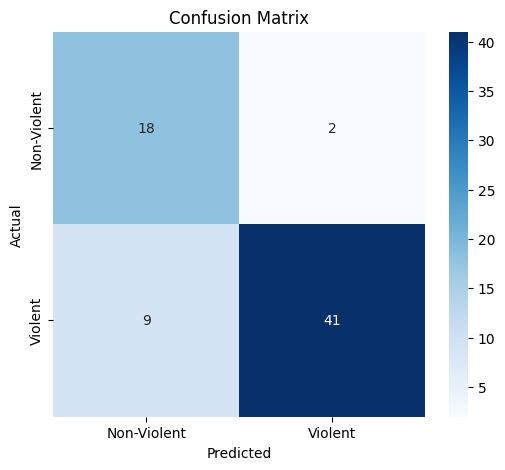

In [8]:
class_names = ['Non-Violent', 'Violent']

# Evaluate model with confusion matrix
evaluate_model(model, val_loader, device, class_names)